# Analyzing the cost of unseen events-aware estimators (RQ3 in the paper)

This notebook provides the analysis of the time taken to compute the estimators.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

# Set dir to this file location.
# For example, os.chdir("{root dir}/notebook/")

output_domain_size_dict = {
    "smartgrid-1": (3, 12),
    "prob-termination-5": (6, 10),
    "prob-termination-7": (8, 10),
    "smartgrid-2": (9, 12),
    "prob-termination-9": (10, 10),
    "prob-termination-12": (13, 20),
    "reservoir-4": (16, 4),
    "window-20": (20, 20),
    "window-24": (24, 24),
    "smartgrid-3": (27, 12),
    "window-28": (28, 28),
    "window-32": (32, 32),
    "reservoir-6": (64, 8),
    "smartgrid-4": (81, 12),
    "smartgrid-5": (243, 12),
    "reservoir-8": (256, 16),
    "random-walk-3": (500, 24),
    "random-walk-5": (500, 31),
    "random-walk-7": (500, 33),
    "random-walk-14": (500, 40),
    "reservoir-10": (1024, 32),
    "reservoir-12": (4096, 64),
}

method_order = [
    "empirical",
    "ChaoFON",
    "ChaoFRN",
    "ChaoION",
    "ChaoIRN",
    "miller",
    "ChaoFOM",
    "ChaoFRM",
    "ChaoIOM",
    "ChaoIRM",
    "HyLeak"
]

## Correlation test

We use Pearson correlation coefficient to measure the correlation between the time taken to compute our best estimators (ChaoSRM) and the size of the joint sample space.

In [8]:
corr_data = []
for subject in output_domain_size_dict.keys():
    data_path = f"../result/time-merged-{subject}-i-xy.csv"
    data = pd.read_csv(data_path)
    data_melt = data.melt(
        id_vars=["Nx", "trial"], var_name="method", value_name="time (s)"
    )
    data_melt = data_melt.groupby(["Nx", "method"]).mean().reset_index()
    data_melt = data_melt[data_melt["method"] == "ChaoIRM"]
    num_x = output_domain_size_dict[subject][0]
    num_xy = (
        output_domain_size_dict[subject][0]
        * output_domain_size_dict[subject][1]
    )
    for row in data_melt.iterrows():
        chao_time = row[1]["time (s)"]
        Nx = row[1]["Nx"]
        corr_data.append(
            (chao_time, Nx * output_domain_size_dict[subject][0], num_x, num_xy)
        )
corr_df = pd.DataFrame(
    corr_data, columns=["time", "num_samples", "num_x", "num_xy"]
)
corr_df


,time,num_samples,num_x,num_xy
0,0.113574,18,3,36
1,0.121575,36,3,36
2,0.122509,72,3,36
3,0.067301,180,3,36
4,0.125706,30,6,60
...,...,...,...,...
83,273.528956,163840,1024,32768
84,1313.771811,131072,4096,262144
85,1667.197068,262144,4096,262144
86,2076.407807,524288,4096,262144


Pearson correlation


,time,num_samples,num_x,num_xy
time,1.000000,0.847764,0.958476,0.977757
num_samples,0.847764,1.000000,0.748731,0.758060
num_x,0.958476,0.748731,1.000000,0.987702
num_xy,0.977757,0.758060,0.987702,1.000000


y=6.94e-03x+-15.32, r=0.98, p=4.05e-60


Text(0.5, 0.5, 'y=0.01x+-15.32, r=0.98, p=0.00')

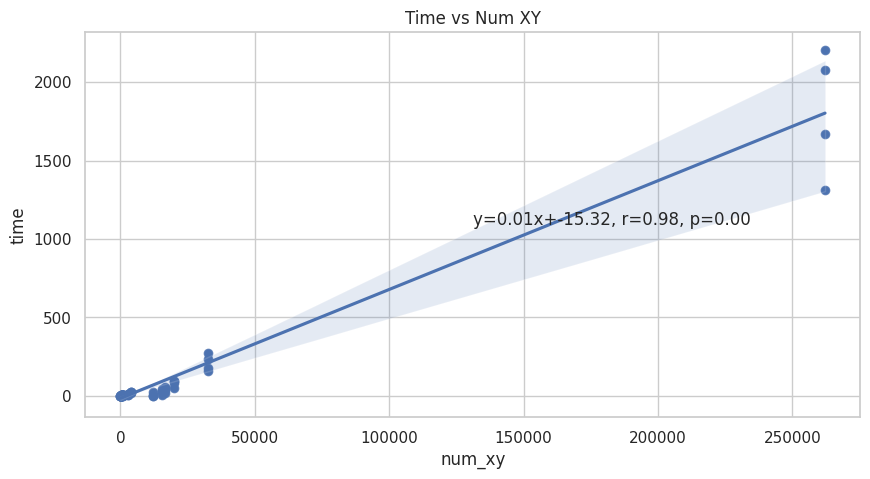

In [9]:
print("Pearson correlation")
display(corr_df.corr(method="pearson"))

fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    x="num_xy",
    y="time",
    data=corr_df,
    ax=ax,
)
ax.set_xlabel("Num XY")
ax.set_ylabel("Time (s)")
ax.set_title("Time vs Num XY")
slope, intercept, r_value, p_value, std_err = stats.linregress(
    corr_df["num_xy"], corr_df["time"]
)
print(f"y={slope:.2e}x+{intercept:.2f}, r={r_value:.2f}, p={p_value:.2e}")
sns.regplot(
    x="num_xy",
    y="time",
    data=corr_df,
    ax=ax,
    line_kws={
        "label": f"y={slope:.2f}x+{intercept:.2f}, r={r_value:.2f}, p={p_value:.2f}"
    },
)
ax.text(
    0.5,
    0.5,
    f"y={slope:.2f}x+{intercept:.2f}, r={r_value:.2f}, p={p_value:.2f}",
    transform=ax.transAxes,
)


## Cost between different configurations

We compare the cost of computing the our estimators with different configurations. We named the eight variants of our estimator as the following scheme: 
- ‘Chao’ 
- \+ ‘F’ (for the FL approach) or ‘S’ (for the BS approach) 
- \+ ‘O’ (for the original MD estimates) or ‘R’ (for the refined MD estimates) 
- \+ ‘N’ (for no bias correction) or ‘M’ (for Miller’s bias correction).

In [10]:
subject_name_map = {
    "smartgrid-1": "SG1",
    "smartgrid-2": "SG2",
    "prob-termination-5": "PT5",
    "prob-termination-7": "PT7",
    "prob-termination-9": "PT9",
    "prob-termination-12": "PT12",
    "smartgrid-3": "SG3",
    "reservoir-6": "RV6",
    "window-20": "WD20",
    "window-24": "WD24",
    "window-28": "WD28",
    "window-32": "WD32",
    "smartgrid-4": "SG4",
    "smartgrid-5": "SG5",
    "reservoir-8": "RV8",
    "random-walk-14": "RW14",
    "random-walk-3": "RW3",
    "random-walk-5": "RW5",
    "random-walk-7": "RW7",
    "reservoir-10": "RV10",
    "reservoir-4": "RV4",
    "reservoir-12": "RV12",
}

df_list = []

for subject in output_domain_size_dict.keys():
    subject_name = subject_name_map[subject]
    data_path = f"../result/time-merged-{subject}-i-xy.csv"
    data = pd.read_csv(data_path)
    data_melt = data.melt(
        id_vars=["Nx", "trial"], var_name="method", value_name="time (s)"
    )
    method_order_s = method_order.copy()
    data_melt["subject"] = subject_name
    df_list.append(data_melt)
total_df = pd.concat(df_list)
total_df = total_df.set_index(["subject", "Nx"]).drop(columns=["trial"])
total_df = total_df.groupby(["subject", "Nx", "method"]).mean()

# rename methods, reorder methods
method_order = [
    "Empirical",
    "FON",
    "FRN",
    "SON",
    "SRN",
    "Miller",
    "FOM",
    "FRM",
    "SOM",
    "SRM",
    "HyLeak",
]

method_rename = {
    "empirical": "Empirical",
    "miller": "Miller",
    "HyLeakH": "HyLeak",
    "ChaoFON": "FON",
    "ChaoFRN": "FRN",
    "ChaoION": "SON",
    "ChaoIRN": "SRN",
    "ChaoFOM": "FOM",
    "ChaoFRM": "FRM",
    "ChaoIOM": "SOM",
    "ChaoIRM": "SRM",
}
total_df = total_df.rename(index=method_rename, level="method")
total_df = total_df.reindex(method_order, level="method")

# compute method's min, mean, median, max time
print(total_df.groupby(["method"]).describe())

          time (s)                                                          \
             count         mean          std       min       25%       50%   
method                                                                       
Empirical     88.0     0.030663     0.105198  0.000138  0.000360  0.001886   
FOM           88.0   287.167822  1189.494690  0.179997  0.757615  6.576394   
FON           88.0   326.286618  1418.100499  0.178759  0.835399  6.742408   
FRM           88.0  1021.658972  4627.838750  0.194497  0.865469  7.727775   
FRN           88.0  1056.937603  4834.506477  0.190655  0.880067  7.945866   
HyLeak        88.0     2.631383    10.970827  0.071833  0.157458  0.250217   
Miller        88.0     0.030914     0.106275  0.000170  0.000397  0.001925   
SOM           88.0    99.639433   377.139381  0.032716  0.348097  2.669800   
SON           88.0    94.661650   361.156686  0.028984  0.348921  2.575755   
SRM           88.0   101.704355   386.615470  0.032713  0.364945

In [11]:
# leave only second smallest Nx
total_df = total_df.reset_index()
total_df = total_df.sort_values(by=["Nx"])
#Adding .copy() to remove the slices warning.
g05 = total_df.groupby(["subject", "method"]).nth(0).copy()
g1 = total_df.groupby(["subject", "method"]).nth(1).copy()
g2 = total_df.groupby(["subject", "method"]).nth(2).copy()
g5 = total_df.groupby(["subject", "method"]).nth(3).copy()

g05["sr"] = 0.5
g1["sr"] = 1
g2["sr"] = 2
g5["sr"] = 5

merge_df = g1 #pd.concat([g05, g1, g2, g5])
merge_df.reset_index(inplace=True)
# drop Nx column
merge_df = merge_df.drop(columns=["Nx"])
merge_df = merge_df.reset_index(drop=True)
merge_df["method"] = pd.Categorical(merge_df["method"], method_order)
# display all rows
pd.set_option("display.max_rows", None)
display(merge_df[merge_df["method"] == "FRN"])
pd.reset_option("display.max_rows")

,index,subject,method,time (s),sr
5,277,RV4,FRN,0.504714,1
19,321,RV6,FRN,6.292130,1
25,57,PT5,FRN,0.360208,1
36,145,PT9,FRN,0.622066,1
51,101,PT7,FRN,0.490909,1
65,629,SG2,FRN,0.685477,1
69,673,SG3,FRN,2.508915,1
85,761,SG5,FRN,50.335035,1
102,717,SG4,FRN,10.925478,1
104,585,SG1,FRN,0.233993,1


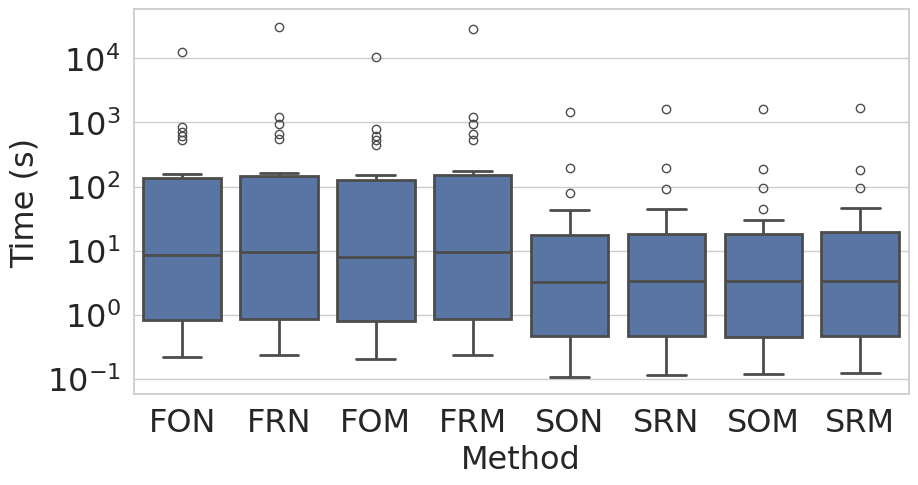

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sub_df = merge_df[~merge_df["method"].isin(["Empirical", "Miller", "HyLeak", "HyLeakC"])].copy()  # Added .copy() to the end to remove the warning.
sub_df["method"] = pd.Categorical(sub_df["method"], ["FON", "FRN", "FOM", "FRM", "SON", "SRN", "SOM", "SRM"])

#sub_df["method"] = pd.Categorical(sub_df["method"], ["FON", "FRN", "FOM", "FRM", "SON", "SRN", "SOM", "SRM"])
sns.boxplot(
    sub_df,
    x="method",
    y="time (s)",
    ax=ax,
    linewidth=2,
)
ax.set_xlabel("Method", fontsize=23)
ax.set_ylabel("Time (s)", fontsize=23)
ax.xaxis.set_tick_params(labelsize=23)
ax.yaxis.set_tick_params(labelsize=23)
ax.set_yscale("log")

plt.savefig(
    "../figures/time-boxplot.pdf", dpi=300, bbox_inches="tight"
)